## 分析A/B测试结果



## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)



In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  **使用你的 dataframe 来回答课堂测试 1 中的问题。**

a. 导入数据集，并在这里查看前几行：

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 使用下面的单元格来查找数据集中的行数。

In [3]:
df.shape[0]

294478

c. 数据集中独立用户的数量。

In [4]:
df.nunique()[0]

290584

d. 用户转化的比例。

In [5]:
df["converted"].mean()

0.11965919355605512

e.  `new_page` 与 `treatment` 不一致的次数。

In [6]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893


f. 是否有任何行存在缺失值？

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。我们应该如何处理这些行？在课堂中的 **测试 2** 中，给出你的答案。  

a. 现在，使用测试题的答案创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [8]:
df2 = pd.read_csv("countries.csv")
df2.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [9]:
df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index,axis=0,inplace=True)

In [10]:
df2 = df2.merge(df,left_on = "user_id",right_on = "user_id",how = "inner")

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 使用 **df2** 与下面的单元格来回答课堂中的 **测试3** 。

a.  **df2** 中有多少唯一的 **user_id**?

In [12]:
df2.nunique()[0]

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [13]:
df2["user_id"].duplicated().sum()

1

In [14]:
pd.Index(df2["user_id"]).get_duplicates()

[773192]

c. 这个重复的  **user_id** 的行信息是什么？

In [15]:
df2.query('user_id == "773192"')

,user_id,country,timestamp,group,landing_page,converted
35136,773192,US,2017-01-09 05:37:58.781806,treatment,new_page,0
35137,773192,US,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除 **一个** 含有重复的 **user_id** 的行， 但需要确保你的 dataframe 为 **df2**。

In [16]:
df2.drop([35137],axis=0,inplace=True)

`4.` 在下面的单元格中，使用 **df2** 来回答与课堂中的 **测试 4** 相关的测试题目。

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [17]:
df2.converted.mean()

0.11959708724499628

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [18]:
control_df = df2.query('group == "control"')['converted'].mean()
control_df

0.1203863045004612

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [19]:
experiment_df = df2.query('group == "treatment"')['converted'].mean()
experiment_df

0.11880806551510564

d. 一个用户收到新页面的概率是多少？


In [20]:
page_converted = df2["landing_page"].value_counts()/df2["landing_page"].value_counts().sum()
page_converted[0]

0.50006194422266881

e. 使用这个问题的前两部分的结果，给出你的建议：你是否认为有证据表明一个页面可以带来更多的转化？在下面写出你的答案。

我认为目前还没有足够的证据表明某一个页面可以带来更多的转化

总体其实是以后收到网站页面的所有用户，所以现在的数据集，其实只是一个样本，我们需要更多样本均值的分布，来帮助我们总体的参数。

<a id='ab_test'></a>
### II - A/B 测试

请注意，由于与每个事件相关的时间戳，你可以在进行每次观察时连续运行假设检验。  

然而，问题的难点在于，一个页面被认为比另一页页面的效果好得多的时候你就要停止检验吗？还是需要在一定时间内持续发生？你需要将检验运行多长时间来决定哪个页面比另一个页面更好？

一般情况下，这些问题是A / B测试中最难的部分。如果你对下面提到的一些知识点比较生疏，请先回顾课程中的“描述统计学”部分的内容。

`1.` 现在，你要考虑的是，你需要根据提供的所有数据做出决定。如果你想假定旧的页面效果更好，除非新的页面在类型I错误率为5％的情况下才能证明效果更好，那么，你的零假设和备择假设是什么？ 你可以根据单词或旧页面与新页面的转化率 **$p_{old}$** 与 **$p_{new}$** 来陈述你的假设。

$$H_0: p_{new} - p_{old}  <= 0$$
$$H_1: p_{new} -  p_{old} >  0$$

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>

使用下面的单元格提供这个模拟的必要内容。如果现在还没有完整的意义，不要担心，你将通过下面的问题来解决这个问题。你可以通过做课堂中的 **测试 5** 来确认你掌握了这部分内容。<br><br>

a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？


In [21]:
p_converted = df2.converted.mean()
p_converted

0.11959708724499628

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [22]:
p_converted = df2.converted.mean()
p_converted

0.11959708724499628

c.  $n_{new}$ 是多少？

In [23]:
n_new = (df2.query('landing_page == "new_page"')["converted"].value_counts()).sum()
n_new

145310

d.  $n_{old}$?是多少？

In [24]:
n_old = (df2.query('landing_page == "old_page"')["converted"].value_counts()).sum()
n_old

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [25]:
zero_prop_new = 1- p_converted
new_page_converted = np.random.choice([0,1],size=n_new,p=[zero_prop_new,p_converted])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [26]:
zero_prop_old = 1- p_converted
old_page_converted = np.random.choice([0,1],size=n_old,p=[zero_prop_old,p_converted])
old_page_converted

array([0, 1, 0, ..., 0, 0, 0])

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [27]:
diff_simulate = new_page_converted.mean() - old_page_converted.mean()
diff_simulate 

0.0028404250909673939

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [28]:
p_diffs = []

for _ in range(10000):
    bootsamp = df2.sample(df2.shape[0],replace=True)
    p_converted = df2.converted.mean()
    n_new = (df2.query('landing_page == "new_page"')["converted"].value_counts()).sum()
    n_old = (df2.query('landing_page == "old_page"')["converted"].value_counts()).sum()
    zero_prop_new = 1- p_converted
    new_page_converted = np.random.choice([0,1],size=n_new,p=[zero_prop_new,p_converted])
    zero_prop_old = 1- p_converted
    old_page_converted = np.random.choice([0,1],size=n_old,p=[zero_prop_old,p_converted])
    
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. 绘制一个 **p_diffs** 直方图。这个直方图看起来像你所期望的吗？通过回答课堂上的匹配问题，确保你完全理解这里计算出的内容。

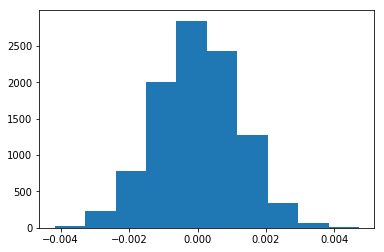

In [29]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

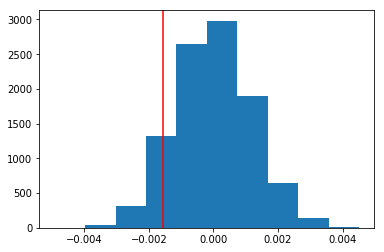

In [30]:
null_vals = np.random.normal(0,p_diffs.std(),p_diffs.size)
obs_diff = df2.query('landing_page == "new_page"')['converted'].mean()-df2.query('landing_page == "old_page"')['converted'].mean()
plt.hist(null_vals);
plt.axvline(x=obs_diff,color="red");

In [31]:
(null_vals > obs_diff).mean()

0.9083

k. 用文字解释一下你刚才在 **j.**中计算出来的结果。在科学研究中，这个值是什么？ 根据这个数值，新旧页面的转化率是否有区别呢？

p 值的定义是 如果零假设为真，观察到统计量 (或支持备择假设的更多极端) 的概率。

这是我们对比实际数据中得到的统计量和零假设中的值，计算被视为极端空值的比例；

在I类错误阀值为5%的情况下，p值（p-value）大于这个阀值；

我们得出的结论是：根据数据，我们无法反对零假设。

即：新页面的转化率并不大于旧页面的转化率。


l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [32]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')["converted"].value_counts()[1]
convert_new = df2.query('landing_page == "new_page"')["converted"].value_counts()[1]
n_old = df2.query('landing_page == "old_page"')["converted"].value_counts().sum()
n_new = df2.query('landing_page == "new_page"')["converted"].value_counts().sum()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. 现在使用 `stats.proportions_ztest` 来计算你的检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的一个有用链接。

In [33]:
sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='smaller')

(1.3109241984234394, 0.90505831275902449)

n. 根据上题算出的 z-score 和 p-value，我们认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 中的结果一致吗？

上题算出的p-value是0.90505831275902449,由于大于在I类错误为5%的阀值，所以新页面的转化率不比旧页面更大。


从结果来看，**j.** 与 **k.** 中的结果不一致，抽样分布中的结果有一定的随机性，而这里的数值确实一个固定值；
从结论来看，和**j.** 与 **k.** 中的结论一致，都得出来相同的结论。

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？


逻辑回归

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [34]:
df2[["control","treatment"]] = pd.get_dummies(df2["group"])
df2["intercept"] = 1

In [35]:
df2.head()

,user_id,country,timestamp,group,landing_page,converted,control,treatment,intercept
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1


In [36]:
df2 = df2.drop("control",axis = 1)

In [37]:
df2.head()

,user_id,country,timestamp,group,landing_page,converted,treatment,intercept
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1



c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [38]:
logit_mod = sm.Logit(df2["converted"],df2[["intercept","treatment"]])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Jul 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:24:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？


与**ab_page** 关联的 p-值是0.190。

因为抽样分布的零假设是 p_new <= p_old,

对立假设是 p_new > p_old；

而在逻辑回归里面，零假设是 β_i = 0

对立假设是β_i ≠ 0；

这就导致了两个检验方法中“对立假设的方向性”有所不同, 从而导致了结果上有所不同。

但是从结论来看，两者都通过数据表明了：新页面的转化率并不高于旧页面的转化率。



f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

因为我们可以通过将其他因素添加到回归模型中，创建一个输入矩阵，同时使用所有这些输入，预测反映变量；

如果我们的自变量彼此相关，就会出现多重共线性。多重共线性的一个主要问题在于：它会导致简单线性回归系数偏离我们想要的方向。

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 你将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

In [40]:
df2[['CA','UK', 'US']] = pd.get_dummies(df2["country"])

df2["intercept"] = 1

logit_mod_country = sm.Logit(df2["converted"],df2[["intercept","treatment","CA","UK"]])

results = logit_mod_country .fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Jul 2018   Pseudo R-squ.:               2.323e-05
Time:                        13:24:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
treatment     -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

由于所求得的p值均大于在I类错误为5%的阀值，所以新页面的转化率不比旧页面更大。

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [41]:
df2['new_CA'] = df2['treatment'] * df2['CA']
df2['new_UK'] = df2['treatment'] * df2['UK']
df2['new_US'] = df2['treatment'] * df2['US']

In [42]:
df2["intercept"] = 1

logit_country2 = sm.Logit(df2["converted"],df2[["intercept","treatment","CA","UK","new_CA","new_UK"]])
result = logit_country2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 12 Jul 2018   Pseudo R-squ.:               3.482e-05
Time:                        13:24:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
treatment     -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
new_CA        -0.0469      0.054     -0.872      0.383      -0.152       0.059
new_UK         0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

从统计结果来看：

无论是从国家与页面在转化率上的个体性因素，还是从页面与国家/地区的相互作用来看，所得到的p-value（p值）均大于在I类错误为5%的阀值，所以新页面的转化率不比旧页面更大。

从实际需要考虑的情况来看：

心理因素——抗拒改变心理：老用户可能会因为纯粹不喜欢改变而偏爱旧版本，哪怕从长远来看新版本更好。
        新奇效应：老用户可能会觉得变化很新鲜，受变化吸引而偏爱新版本，哪怕从长远看来新版本并无益处。
        
       
   有一个非常严肃的潜在问题是，即使我们从这个样本数据中得到了“新页面并不比旧页面的转化率更高”这样的结论，但是只是从数据集中我们并不能确认这是一个能够足够代表整体的样本，我们并不能从数据集中找到相关的证据。